In [9]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [10]:
def plot_3D(x, y, u):
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,u[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,2*numpy.pi)
    ax.set_ylim(0,2*numpy.pi)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)

In [41]:
N = 25
x = numpy.linspace(0,2*numpy.pi,N)
y = numpy.linspace(0,2*numpy.pi,N)
X,Y = numpy.meshgrid(x,y)

nu = 1

dh = 2*numpy.pi/(N-1)


In [42]:
Xu,Yu = X,Y+0.5*dh
Xv,Yv = X+0.5*dh,Y
Xpl = numpy.ones((N+1,N+1))
Ypl = numpy.ones((N+1,N+1))
Xpl[1:,1:] = X+0.5*dh
Xpl[:,0] = -0.5*dh
Xpl[0,:] = Xpl[1,:]
Ypl[1:, 1:] = Y+0.5*dh
Ypl[0,:] = -0.5*dh
Ypl[:,0]=Ypl[:,1]

In [43]:
u_exactf = -numpy.exp(-2*0)*numpy.cos(Xu)*numpy.sin(Yu)
v_exactf = numpy.exp(-2*0)*numpy.sin(Xv)*numpy.cos(Yv)
p_exactf = -numpy.exp(-4*0)/4*(numpy.cos(2*Xpl)+numpy.cos(2*Ypl))
#print(u_exactf)
# at t=0, initial guess
u_i = -numpy.cos(Xu)*numpy.sin(Yu)
v_i = numpy.sin(Xv)*numpy.cos(Yv)
p_i = -1/4*(numpy.cos(2*Xpl)+numpy.cos(2*Ypl))

#pyplot.figure(figsize=(5,5))
#pyplot.contour(X,Y,u_i)

In [44]:
#N = 20
#dh = 2*numpy.pi/(N-1)
CFL = 0.3 # 0.4 or 0.3 or 2.51
sigma = 0.62
maxu,maxv = numpy.max(numpy.absolute(u_exactf)), numpy.max(numpy.absolute(v_exactf))
print(maxu,maxv)
maxim = max(maxu,maxv)

dtc = CFL*dh/maxim
dtv = sigma/nu*dh**2   #stability condition
print(dtc,dtv)
dt = min(dtc,dtv)
#dt = 0.02
nt = int(2/dt +1)
print(nt)
#nt=10

0.991444861374 0.991444861374
0.0792175333189 0.04249413006024584
48


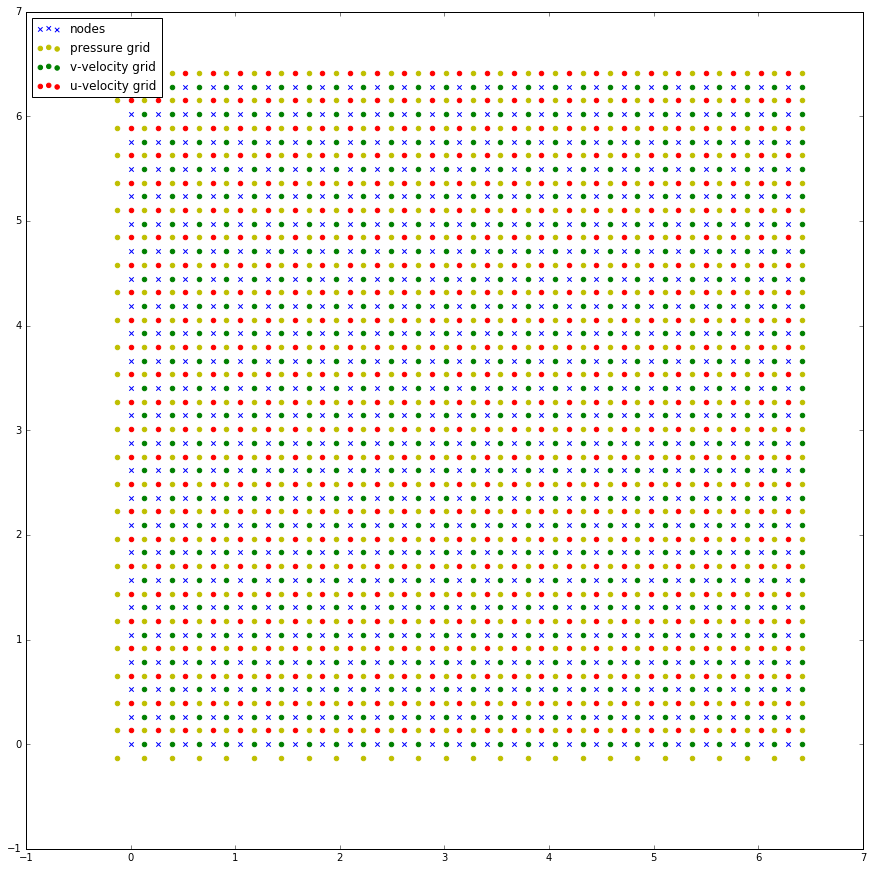

In [15]:
pyplot.figure(figsize=(15,15))
#pyplot.xlim(0,2*numpy.pi)
#pyplot.ylim(0,2*numpy.pi)
pyplot.scatter(X,Y,label='nodes',marker='x')
pyplot.scatter(Xpl,Ypl,color='y',label='pressure grid')

pyplot.scatter(Xv,Yv,color='g',label='v-velocity grid')
pyplot.scatter(Xu,Yu,color='r',label='u-velocity grid')
pyplot.legend(loc=2);

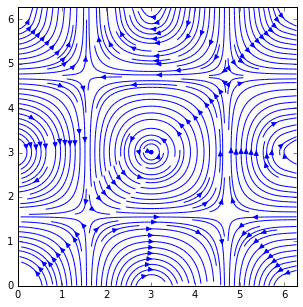

In [16]:
pyplot.figure(figsize=(5,5))
pyplot.xlim(0,2*numpy.pi)
pyplot.ylim(0,2*numpy.pi)
pyplot.streamplot(X,Y,u_i,v_i, density=2);

In [17]:
def convective_flux_x(u,v,dh):
    #divergence of convective flux in x-dir 
    
    F_cx = -1/(4*dh)*( (u[1:-1,1:-1]+u[1:-1,2:])**2 - (u[1:-1,1:-1]+u[1:-1,:-2])**2 +\
        (u[1:-1,1:-1]+u[2:,1:-1])*(v[1:-1,2:]+v[1:-1,1:-1]) - (u[1:-1,1:-1]+u[:-2,1:-1])*(v[:-2,2:]+v[:-2,1:-1]) )
    return F_cx

def pressure_flux_x(p,dh):
    #divergence of pressure flux in x-dir

    F_px = -(p[1:-1,2:]-p[1:-1,1:-1])/dh
    return F_px

def viscous_flux_x(u,v,nu,dh):
    # divergence of viscous flux in x-dir
    
    F_vx = nu/dh**2*( u[1:-1,2:] -4*u[1:-1,1:-1] + u[1:-1,:-2] + u[2:,1:-1] + u[:-2,1:-1] )
    return F_vx

def convective_flux_y(u,v,dh):   #####CHECK THIS#####
    F_cy = -1/(4*dh)*( (v[1:-1,1:-1]+v[2:,1:-1])**2 - (v[1:-1,1:-1]+v[:-2,1:-1])**2 +\
        (v[1:-1,1:-1]+v[1:-1,2:])*(u[2:,1:-1]+u[1:-1,1:-1]) - (v[1:-1,1:-1]+v[1:-1,:-2])*(u[2:,:-2]+u[1:-1,:-2]) )
    return F_cy

def pressure_flux_y(p,dh):
    F_py = -(p[2:,1:-1]-p[1:-1,1:-1])/dh
    return F_py

def viscous_flux_y(u,v,nu,dh):   #####CHECK THIS#####
    F_vy = nu/dh**2*( v[1:-1,2:] - 4*v[1:-1,1:-1] + v[1:-1,:-2] + v[2:,1:-1] + v[:-2,1:-1] )
    return F_vy

In [18]:
def divcheck(u,v,dh,N):
    divergence = numpy.zeros((N,N))
    divergence = (u[1:-1,2:]-u[1:-1,1:-1]+v[2:,1:-1]-v[1:-1,1:-1])/dh
    return divergence

In [19]:
def poisson_IG(N,dt,ustar,vstar):
    
    f = 1/dt*( (ustar[:-1,1:]-ustar[:-1,:-1])/dh + (vstar[1:,:-1]-vstar[:-1,:-1])/dh )
    
    #p_i = numpy.zeros((N,N))    #initial guess
    
    l2_target = 1e-8
    omega = 2/(1+(numpy.pi/N))
    return f,l2_target,omega

def poisson_SOR(p,pn,l2_target,omega,f,dh):
    iterations = 0
    iter_diff = l2_target + 1
    denominator = 0.0
    ny,nx=p.shape
    l2_diff = numpy.zeros(20000)
    
    while iter_diff > l2_target:
        for j in range(N):
            for i in range(N):
                pn[j,i]=p[j,i]
                
        iter_diff = 0.0
        denominator = 0.0
        
        for j in range(1,N-1):
            for i in range(1,N-1):
                p[j,i] = (1-omega)*p[j,i] + omega * ((p[j,i+1]+p[j,i-1])*dh**2 +\
                    (p[j+1,i] + p[j-1,i])*dh**2 -f[j,i]*dh**2*dh**2)/(2*(dh**2 + dh**2))
                
        #enforce neumann bc on boundaries
        for j in range(N):
            p[j,0] = p[j,1]    #left boundary
            p[j,-1] = p[j,-2]    #right boundary
        for i in range(N):
            p[0,i] = p[1,i]    #bottom boundary
            p[-1,i] = p[-2,i]    #top boundary
        
        #corners, set equal to one of the sides
        p[0,0]=(p[0,1] + p[1,0])/2   #bottom left corner
        p[0,-1]=(p[0,-2] + p[1,-1])/2   #bottom right corner
        p[-1,-1]=(p[-2,-1] + p[-1,-2])/2    #top right corner
        p[-1,0]=(p[-2,0] + p[-1,1])/2   #top left corner
            
        for j in range(N):
            for i in range(N):
                iter_diff += (p[j,i]-pn[j,i])**2
                denominator += (pn[j,i]*pn[j,i])
                
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_diff[iterations] = iter_diff
        iterations +=1
        
        if iterations > 5000:
            break
        
    #print("SOR method took {} iterations at tolerance {} with omega = {} and nx = {}".format(iterations, l2_target, omega,N))

        
    return p,iterations,l2_diff

In [20]:
def ic(Xu,Yu,Xv,Yv,Xpl,Ypl,dh,nu):
    
    # at t=0, initial guess
    u_i = -numpy.cos(Xu)*numpy.sin(Yu)
    v_i = numpy.sin(Xv)*numpy.cos(Yv)
    p_i = -1/4*(numpy.cos(2*Xpl)+numpy.cos(2*Ypl))
     
    u_e = -numpy.exp(-2*0)*numpy.cos(Xu)*numpy.sin(Yu)
    v_e = numpy.exp(-2*0)*numpy.sin(Xv)*numpy.cos(Yv)
    
    u_i[:,0] = u_e[:,0]
    u_i[:,-1] = u_e[:,-1]
    u_i[0,:] = u_e[0,:]
    u_i[-1,:] = u_e[-1,:]
    
    v_i[0,:] = v_e[0,:]
    v_i[-1,:] = v_e[-1,:]
    v_i[:,0] = v_e[:,0]
    v_i[:,-1] = v_e[:,-1]
    
    p_i[0,:] = p_i[1,:]
    p_i[-1,:] = p_i[-2,:]
    p_i[:,0] = p_i[:,1]
    p_i[:,-1] = p_i[:,-2]
    
    F_cx_i = convective_flux_x(u_i,v_i,dh)
    F_vx_i = viscous_flux_x(u_i,v_i,nu,dh)
    F_cy_i = convective_flux_y(u_i,v_i,dh)
    F_vy_i = viscous_flux_y(u_i,v_i,nu,dh)
    
    return u_i,v_i,p_i,F_cx_i,F_vx_i,F_cy_i,F_vy_i

In [21]:
def ab(u,v,p,F_cx,F_vx,F_cy,F_vy,dh,dt,nt,nu,Xu,Yu,Xv,Yv):   #####ADD BCs#####
    
    u_n = numpy.zeros((nt,len(u),len(u)))
    v_n = numpy.zeros((nt,len(v),len(v)))
    p_n = numpy.zeros((nt,len(p),len(p)))
    F_cx_n = numpy.zeros((nt,len(F_cx),len(F_cx)))
    F_vx_n = numpy.zeros((nt,len(F_vx),len(F_vx)))
    F_cy_n = numpy.zeros((nt,len(F_cy),len(F_cy)))
    F_vy_n = numpy.zeros((nt,len(F_vy),len(F_vy)))
    
    u_n[:,:,:] = u.copy()    #hold u-comp vel for each timestep
    v_n[:,:,:] = v.copy()    #hold v-comp vel for each timestep
    p_n[:,:,:] = p.copy()    #hold pressure for each timestep
    F_cx_n[:,:,:] = F_cx.copy()
    F_vx_n[:,:,:] = F_vx.copy()
    F_cy_n[:,:,:] = F_cy.copy()
    F_vy_n[:,:,:] = F_vy.copy()
    
    u_e = numpy.zeros((nt,len(u),len(u)))
    v_e = numpy.zeros((nt,len(u),len(u)))
    t=numpy.linspace(0,2,nt)
    for i in range(1,nt):
        #u_i = -numpy.exp(-2*(t-1))*numpy.cos(Xu)*numpy.sin(Yu)
        #v_i = numpy.exp(-2*(t-1))*numpy.sin(Xv)*numpy.cos(Yv)
        #p_i = -numpy.exp(-4*(t-1))/4*(numpy.cos(2*Xpl)+numpy.cos(2*Ypl))
        
        un=u.copy()
        vn=v.copy()
        pn=p.copy()
        
        
        u_e[i,:,:] = -numpy.exp(-2*t[i])*numpy.cos(Xu)*numpy.sin(Yu)
        v_e[i,:,:] = numpy.exp(-2*t[i])*numpy.sin(Xv)*numpy.cos(Yv) 
        
        ustar = u.copy()#numpy.zeros_like(u)
        vstar = v.copy()#numpy.zeros_like(u)
        
        #velocity prediction
        F_cx_n[i,:,:] = convective_flux_x(u,v,dh)
        F_vx_n[i,:,:] = viscous_flux_x(u,v,nu,dh)
        ustar[1:-1,1:-1] = un[1:-1,1:-1] + 3/2*dt*(F_cx_n[i,:,:]+F_vx_n[i,:,:])+0.5*dt*(F_cx_n[i-1,:,:]+F_vx_n[i-1,:,:])
        
        F_cy_n[i,:,:] = convective_flux_y(u,v,dh)
        F_vy_n[i,:,:] = viscous_flux_y(u,v,nu,dh)
        vstar[1:-1,1:-1] = vn[1:-1,1:-1] + 3/2*dt*(F_cy_n[i,:,:]+F_vy_n[i,:,:])+0.5*dt*(F_cy_n[i-1,:,:]+F_vy_n[i-1,:,:])
        
        divergence = divcheck(ustar,vstar,dh,N)
        
        # normal component boundary conditions
        #ustar[:,0] = ustar[:,1]#u_e[i,:,0]
        #ustar[:,-1] = ustar[:,-2]#u_e[i,:,-1]
        
        ustar[0,:] = u_e[i,0,:] #ustar[:,1]
        ustar[-1,:] = u_e[i,-1,:] #ustar[-2,:]
        
        #vstar[0,:] = vstar[1,:]#v_e[i,0,:]
        #vstar[-1,:] = vstar[-2,:]#v_e[i,-1,:]
        
        vstar[:,0] = v_e[i,:,0] #vstar[1,:]
        vstar[:,-1] = v_e[i,:,-1] #vstar[:,-2]
        
        #poisson to solve for pressure
        f,l2_target,omega = poisson_IG(N,dt,ustar,vstar)
        p_n[i,:,:],iterations,l2_diff = poisson_SOR(pn.copy(),pn.copy(),l2_target,omega,f,dh)
        
       
        
        #velocity correction
        F_px = pressure_flux_x(p_n[i,:,:],dh)
        u_n[i,1:-1,1:-1] = ustar[1:-1,1:-1] + dt*F_px[1:,1:]
        F_py = pressure_flux_y(p_n[i,:,:],dh)
        v_n[i,1:-1,1:-1] = vstar[1:-1,1:-1] + dt*F_py[1:,1:]
        
        #BC for all components
        u_n[i,:,0] = u_e[i,:,0]#u_n[i,:,1]
        u_n[i,:,-1] = u_e[i,:,-1]#u_n[i,:,-2]
        
        u_n[i,0,:] =  u_e[i,0,:] #u_n[i,1,:]
        u_n[i,-1,:] = u_e[i,-1,:]#u_n[i,-2,:]
        
        v_n[i,0,:] =  v_e[i,0,:]#v_n[i,1,:]
        v_n[i,-1,:] = v_e[i,-1,:]#v_n[i,-2,:]
        
        v_n[i,:,0] = v_e[i,:,0]
        v_n[i,:,-1] = v_e[i,:,-1]
      
        
        #move to u and v
        u = u_n[i].copy()
        v = v_n[i].copy()
        p = p_n[i].copy()
        
        if i == int(nt/2):
            print('half done')
        
    return u_n,v_n,p_n,l2_target,iterations,l2_diff,divergence,u_e,v_e

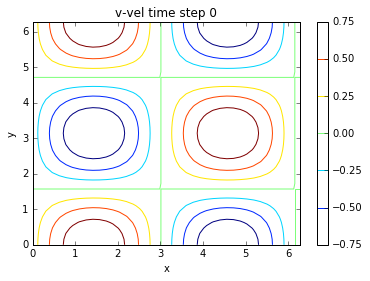

In [114]:
u_i,v_i,p_i,F_cx_i,F_vx_i,F_cy_i,F_vy_i = ic(Xu,Yu,Xv,Yv,Xpl,Ypl,dh,nu)
#pyplot.xlim(0,2*numpy.pi)
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('v-vel time step 0')
pyplot.contour(X,Y,v_i)
pyplot.colorbar();

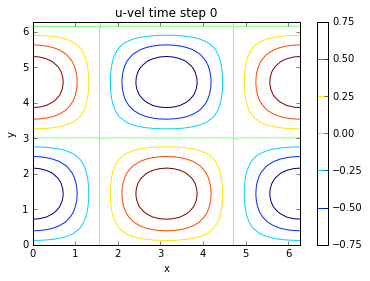

In [115]:
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('u-vel time step 0')
pyplot.contour(X,Y,u_i)
pyplot.colorbar();

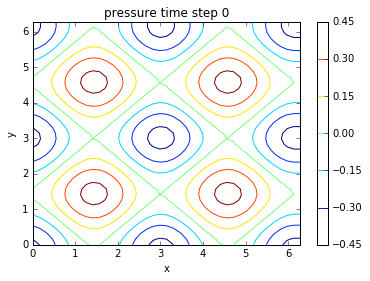

In [133]:
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('pressure time step 0')
pyplot.contour(X,Y,p_i[1:,1:])
pyplot.colorbar();

In [24]:
u_n,v_n,p_n,l2_target,iterations,l2_diff,divergence,u_e,v_e = ab(u_i.copy(),v_i.copy(),p_i.copy(),F_cx_i.copy(),F_vx_i.copy(),F_cy_i.copy(),F_vy_i.copy(),dh,dt,nt,nu,Xu,Yu,Xv,Yv)

half done


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:46: RuntimeWarning: overflow encountered in double_scalars
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:47: RuntimeWarning: overflow encountered in double_scalars
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in double_scalars
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in square
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in multiply
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in square
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in

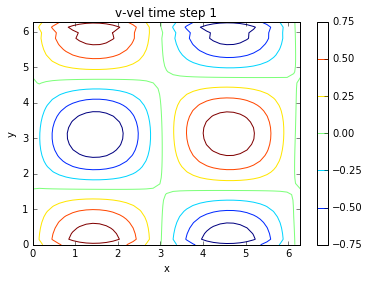

12


In [116]:
#pyplot.figure(figsize=(5,5))
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('v-vel time step 1')
pyplot.contour(X,Y,v_n[1,:,:])
#pyplot.contourf(X,Y,v_n[-1,:,:])
pyplot.colorbar()
pyplot.show();
print(nt)

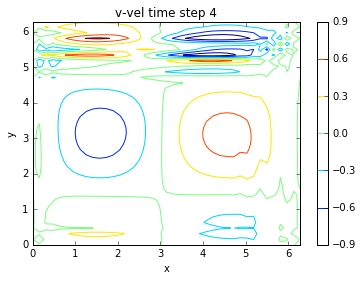

In [121]:
#pyplot.figure(figsize=(5,5))
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('v-vel time step 4')
pyplot.contour(X,Y,v_n[4,:,:])
#pyplot.contourf(X,Y,v_n[-1,:,:])
pyplot.colorbar()
pyplot.show();


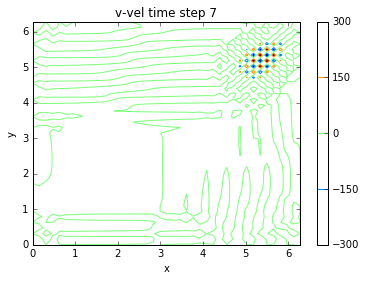

In [122]:
#pyplot.figure(figsize=(5,5))
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('v-vel time step 7')
pyplot.contour(X,Y,v_n[7,:,:])
#pyplot.contourf(X,Y,v_n[-1,:,:])
pyplot.colorbar()
pyplot.show();


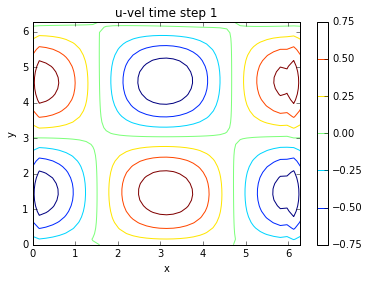

In [126]:
#pyplot.figure(figsize=(5,5))
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('u-vel time step 1')
pyplot.contour(X,Y,u_n[1,:,:])
#pyplot.contourf(X,Y,v_n[-1,:,:])
pyplot.colorbar()
pyplot.show();


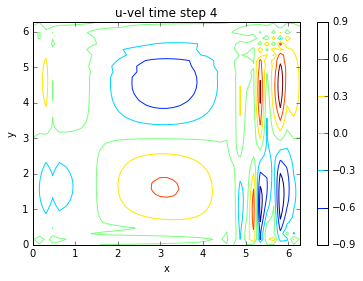

In [127]:
#pyplot.figure(figsize=(5,5))
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('u-vel time step 4')
pyplot.contour(X,Y,u_n[4,:,:])
#pyplot.contourf(X,Y,v_n[-1,:,:])
pyplot.colorbar()
pyplot.show();

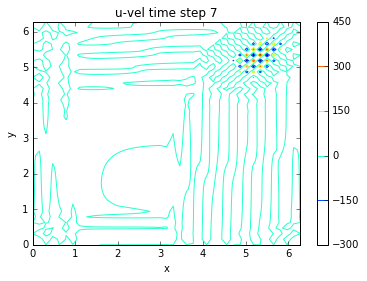

In [128]:
#pyplot.figure(figsize=(5,5))
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('u-vel time step 7')
pyplot.contour(X,Y,u_n[7,:,:])
#pyplot.contourf(X,Y,v_n[-1,:,:])
pyplot.colorbar()
pyplot.show();

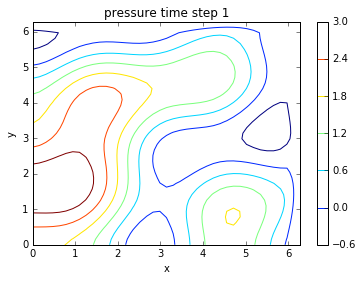

In [130]:
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('pressure time step 1')
pyplot.contour(X,Y,p_n[1,1:,1:])
pyplot.colorbar()
pyplot.show();

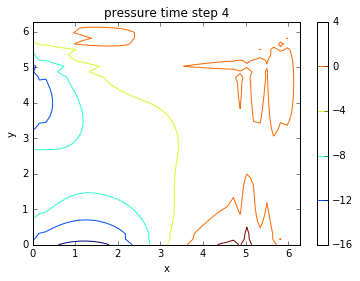

In [131]:
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('pressure time step 4')
pyplot.contour(X,Y,p_n[4,1:,1:])
pyplot.colorbar()
pyplot.show();

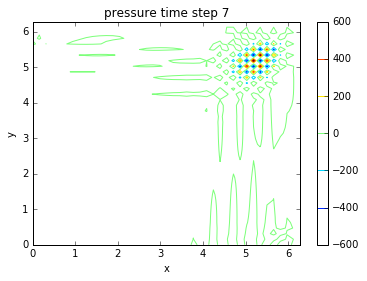

In [132]:
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('pressure time step 7')
pyplot.contour(X,Y,p_n[7,1:,1:])
pyplot.colorbar()
pyplot.show();

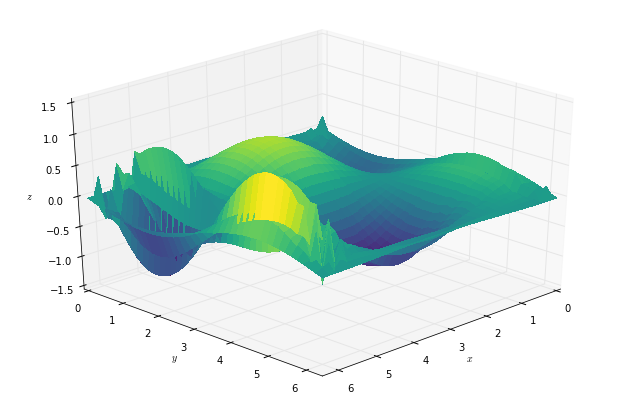

In [111]:
plot_3D(x,y,u_n[4,:,:])    #u-vel time step 4

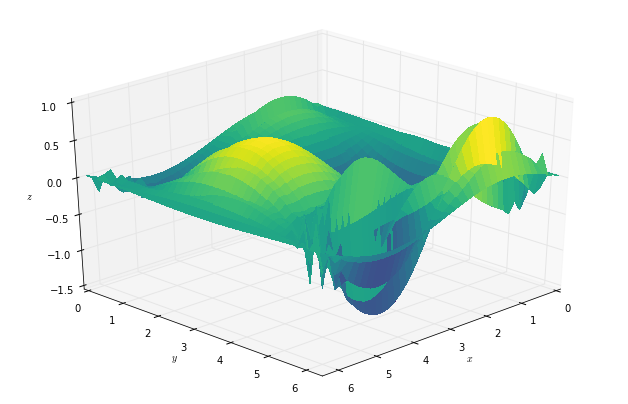

In [135]:
plot_3D(x,y,v_n[4,:,:])   #v-vel time step 4

# spatial and time convergence

In [39]:
def L2_error(u,u_e):
    error = numpy.sqrt(numpy.sum((u-u_e)**2)/numpy.sum(u_e)**2)
    return error

def anal(t,Xu,Yu,Xv,Yv,Xpl,Ypl):
    u_exact = -numpy.exp(-2*t)*numpy.cos(Xu)*numpy.sin(Yu)
    v_exact = numpy.exp(-2*t)*numpy.sin(Xv)*numpy.cos(Yv)
    p_exact = -numpy.exp(-4*t)/4*(numpy.cos(2*Xpl))
    return u_exact,v_exact,p_exact

In [46]:
N = 25
dx = 2*numpy.pi/(N-1)

dt_values=numpy.asarray([1.0,0.5,0.25,0.125])
error = numpy.zeros(len(dt_values))
x = numpy.linspace(0,2*numpy.pi,N)
y = numpy.linspace(0,2*numpy.pi,N)
X,Y = numpy.meshgrid(x,y)
Xu,Yu = X,Y+0.5*dh
Xv,Yv = X+0.5*dh,Y
Xpl = numpy.ones((N+1,N+1))
Ypl = numpy.ones((N+1,N+1))
Xpl[1:,1:] = X+0.5*dh
Xpl[:,0] = -0.5*dh
Xpl[0,:] = Xpl[1,:]
Ypl[1:, 1:] = Y+0.5*dh
Ypl[0,:] = -0.5*dh
Ypl[:,0]=Ypl[:,1]
u_exact,v_exact,p_exact = anal(2,Xu,Yu,Xv,Yv,Xpl,Ypl)

for i,dt in enumerate (dt_values):
    nt = int(2/dt +1)
    u_i,v_i,p_i,F_cx_i,F_vx_i,F_cy_i,F_vy_i = ic(Xu,Yu,Xv,Yv,Xpl,Ypl,dh,nu)
    
    u_n,v_n,p_n,l2_target,iterations,l2_diff,divergence,u_e,v_e = ab(u_i.copy(),v_i.copy(),p_i.copy(),F_cx_i.copy(),F_vx_i.copy(),F_cy_i.copy(),F_vy_i.copy(),dh,dt,nt,nu,Xu,Yu,Xv,Yv)
    error[i]=L2_error(u_n[-1,:,:],u_exact)

half done
half done
half done
half done


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:46: RuntimeWarning: overflow encountered in double_scalars
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:47: RuntimeWarning: overflow encountered in double_scalars
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in double_scalars
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in square
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in multiply
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in square
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in

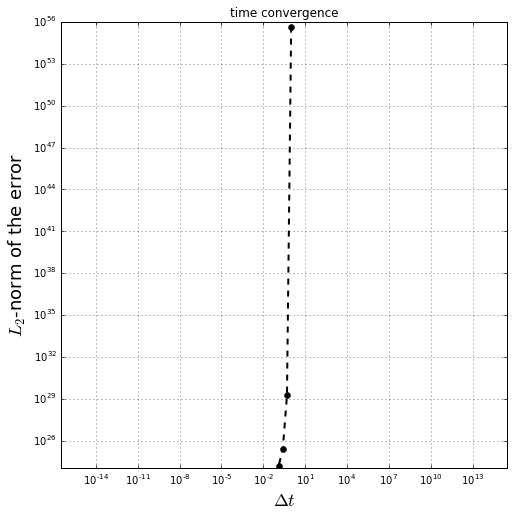

In [108]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel(r'$\Delta t$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.axis('equal')
pyplot.title('time convergence')
pyplot.loglog(dt_values, error, color='k', ls='--', lw=2, marker='o')
#pyplot.loglog(dt_values, error_ftcs, color='k', ls='--', lw=2, marker='s')
#pyplot.legend(['Crank-Nicolson', 'FTCS']);

In [78]:
nx_values = numpy.asarray([11,21,31,41])

CFL = 0.3 # 0.4 or 0.3 or 2.51
sigma = 0.62

error = numpy.zeros(len(nx_values))
u_exact,v_exact,p_exact = anal(2,Xu,Yu,Xv,Yv,Xpl,Ypl)
for i, nx in enumerate(nx_values):
    N=nx
    dx = 2*numpy.pi/(nx-1)
    x = numpy.linspace(0,2*numpy.pi,nx)
    y = numpy.linspace(0,2*numpy.pi,nx)
    X,Y = numpy.meshgrid(x,y)
    
    Xu,Yu = X,Y+0.5*dh
    Xv,Yv = X+0.5*dh,Y
    Xpl = numpy.ones((N+1,N+1))
    Ypl = numpy.ones((N+1,N+1))
    Xpl[1:,1:] = X+0.5*dh
    Xpl[:,0] = -0.5*dh
    Xpl[0,:] = Xpl[1,:]
    Ypl[1:, 1:] = Y+0.5*dh
    Ypl[0,:] = -0.5*dh
    Ypl[:,0]=Ypl[:,1]
    
    u_exact,v_exact,p_exact = anal(2,Xu,Yu,Xv,Yv,Xpl,Ypl)
    u_i,v_i,p_i,F_cx_i,F_vx_i,F_cy_i,F_vy_i = ic(Xu,Yu,Xv,Yv,Xpl,Ypl,dh,nu)
    maxu,maxv = numpy.max(numpy.absolute(u_exactf)), numpy.max(numpy.absolute(v_exactf))
    maxim = max(maxu,maxv)

    dtc = CFL*dh/maxim
    dtv = sigma/nu*dh**2
    dt = min(dtc,dtv)
    nt = int((2/dt +1)/4)
    u_n,v_n,p_n,l2_target,iterations,l2_diff,divergence,u_e,v_e = ab(u_i.copy(),v_i.copy(),p_i.copy(),F_cx_i.copy(),F_vx_i.copy(),F_cy_i.copy(),F_vy_i.copy(),dh,dt,nt,nu,Xu,Yu,Xv,Yv)
    error[i]=L2_error(u_n[-1,:,:],u_exact)

half done
half done
half done
half done


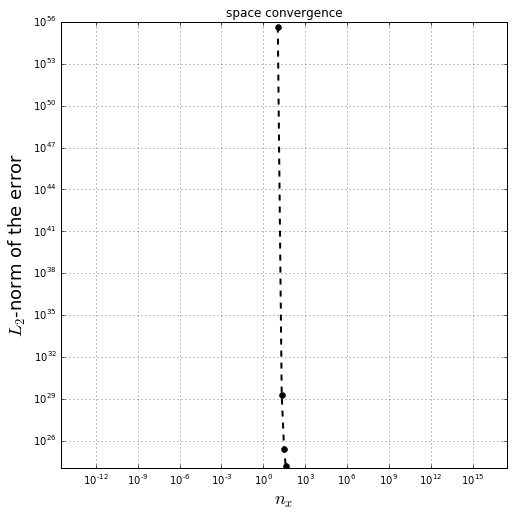

In [109]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.title('space convergence')
pyplot.axis('equal')
pyplot.loglog(nx_values, error, color='k', ls='--', lw=2, marker='o');

In [53]:
error

array([ nan,  nan,  nan,  nan])

In [81]:
numpy.min(divergence),numpy.max(divergence)

(-1.0709482907660544e+22, 1.7105436026134331e+22)

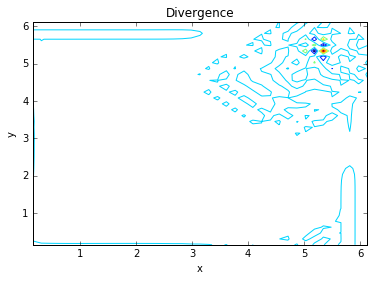

In [86]:
pyplot.contour(X[1:-1,1:-1],Y[1:-1,1:-1],divergence)
pyplot.title('Divergence')
pyplot.xlabel('x')
pyplot.ylabel('y');

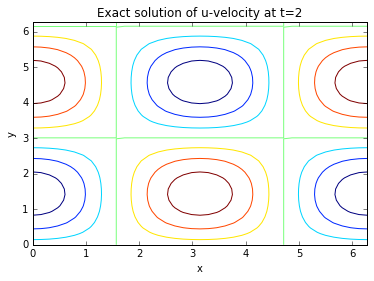

In [93]:
pyplot.contour(X,Y,u_e[-1,:,:])
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('Exact solution of u-velocity at t=2');

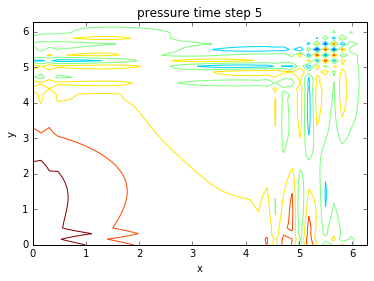

In [107]:
pyplot.contour(X,Y,p_n[5,1:,1:])
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('pressure time step 5');